# Introduction

### Description: Navigating News Narratives - A Media Bias Analysis Dataset

The dataset combines news data from various reputable sources with more than 3.7 million rows covering a broad range of news topics and biases such as hate speech, toxicity, sexism, ageism, gender, racial and more. For this project, our focus will be on racial bias only.

Estimated size: 3.7 million rows and 6 columns (960 MB)
Location: https://huggingface.co/datasets/newsmediabias/news-bias-full-data
Format: Comma Separated Values (.csv)
Access method: Download csv file

#### More About the Dataset (Variables)
Text: The main content.
Dimension: Descriptive category of the text.
Biased_Words: A compilation of words regarded as biased.
Aspect: Specific sub-topic within the main content.
Label: Indicates the level of bias. The label is ternary - highly biased, slightly biased and neutral
Sentiment: Postive, Negative and Neutral

### Import Libraries

To start data cleaning and manipulation, we are going to import and install some helper libraries that we will need to process the data.

In [ ]:
import re
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

!pip install contractions
import contractions

!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 21.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.6/513.6 kB 42.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


#### Load dataset

In [ ]:
# Load dataset
data = pd.read_csv('/work/newsmediabias-full.csv')

print(f"Dataset shape: {data.shape}")
print("First few rows of the dataset:")
data.head()

Dataset shape: (3721239, 6)
First few rows of the dataset:


,text,dimension,biased_words,aspect,label,sentiment
0,is upset that he can't update his Facebook by ...,Ageism and sentiment,[],Relationship status,Slightly Biased,Negative
1,@Kenichan I dived many times for the ball. Man...,Ageism and sentiment,[],Selection,Neutral,Positive
2,my whole body feels itchy and like its on fire,Ageism and sentiment,['itchy'],Body-shaming,Highly Biased,Negative
3,"@nationwideclass no, it's not behaving at all....",Ageism and sentiment,[],Nation stereotype,Slightly Biased,Negative
4,@Kwesidei not the whole crew,Ageism and sentiment,[],Perspective,Neutral,Neutral


# Data Cleaning and Manipulation

The entire dataset covers biases such as hate speech, toxicity, sexism, ageism, gender, racial and more. Since our project's focus is detecting racial bias, we will select a subset of the dataset where the sub topic within the main content is 'Racial'.

In [ ]:
# Select rows where the 'aspect' column is 'Racial'
r_bias_data = data[data['aspect'] == 'Racial']

print(f"Number of rows with 'Racial' in the 'aspect' column: {r_bias_data.shape[0]}")

Number of rows with 'Racial' in the 'aspect' column: 41769


Next, we will start with dropping duplicate rows to ensure that each row is unique and avoid any redundancy in the dataset.

In [ ]:
# Check for duplicate records
print(f"Number of duplicate records: {r_bias_data.duplicated().sum()}")

# Remove duplicate records
r_bias_data = r_bias_data.drop_duplicates()
print(f'Total number of unique records after removing duplicates: {r_bias_data.shape[0]}')

Number of duplicate records: 1939
Total number of unique records after removing duplicates: 39830


Then, we will take a look at the missing values, if any, and then decide how to handle them.

In [ ]:
print(f"Missing values in each column: \n{r_bias_data.isnull().sum()}")

Missing values in each column: 
text            1
dimension       0
biased_words    0
aspect          0
label           0
sentiment       0
dtype: int64


How we handle missing values in a dataset is important and there are few options to best deal with them such as drop any rows or columns that contain missing data but this can result in loss of potentially useful data. Another option is we impute the missing values using techniques like mean or median imputation. 

Since there's only one row with missing value in the 'text' column, we will take a look at the row and remove it, if removing it will not be a loss of any valuable information and will not significantly affect our analysis.

In [ ]:
# Identify the row with missing values in the 'text' column
r_bias_data[r_bias_data['text'].isnull()]

,text,dimension,biased_words,aspect,label,sentiment
2429711,NaN,toxicity,[],Racial,Neutral,Neutral


In [ ]:
# Remove row with missing values in the text column
r_bias_data.dropna(subset=['text'], inplace=True)

# Verify
r_bias_data.isnull().sum()

text            0
dimension       0
biased_words    0
aspect          0
label           0
sentiment       0
dtype: int64

In [ ]:
# Take a look at the columns, count and data types
print(r_bias_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 39829 entries, 74 to 3721113
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          39829 non-null  object
 1   dimension     39829 non-null  object
 2   biased_words  39829 non-null  object
 3   aspect        39829 non-null  object
 4   label         39829 non-null  object
 5   sentiment     39829 non-null  object
dtypes: object(6)
memory usage: 2.1+ MB
None


### Preprocessing

Next, we will perform some additional preprocessing steps such as text preprocessing which will be immensely helpful for our NLP tasks where having a clean and clear text data will be essential for further analysis. 

We will define a helper function to expand the contractions such as i'll, won't, can't and so on to their full forms like I will, will not, cannot and so on. Doing this will make sure each word is accurately recognised and processed and can help improve the accuracy of tokenization and lemmatization.

In [ ]:
# Define a helper function
def expand_contractions(text):
    return contractions.fix(text)

Then we will define a text preprocessing function that will help us clean the text by expanding the contractions, lowercasing text data,removing Twitter handles (if any), removing any links and non-alphabetic characters, tokenizing text into individual words, removing stopwords and lemmatizing. And save the clean text data under new column 'preprocessed_text'.

To reduce the tokenized words to their base or root form, we have couple of options: stemming or lemmatizing. We went with lemmatizing as it is more sophisticated although it can be a little slower than stemming as it is utilizing more resources which ultimately helps us with the reductions being more accurate and meaningful.

In [ ]:
# Define a text preprocessing function
def preprocess_text(text):
    text = expand_contractions(text)                #expand contractions
    text = text.lower()                             #convert text to lowercase
    text = re.sub(r'@\w+', '', text)                #remove twitter handles
    text = re.sub(r'http\S+|www.\S+|\S+\.(com|org|net|edu|gov)\b', '', text)     #remove URLs
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)        #remove non-alphabetic characters

    tokens = nltk.word_tokenize(text)               #tokenize the text

    stop_words = set(stopwords.words('english'))    #remove stopwords
    tokens = [token for token in tokens if token not in stop_words]

    lemmatizer = WordNetLemmatizer()                #lemmatize tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)                         

# Apply preprocess_text function to create a new column 'preprocessed_text'
r_bias_data['preprocessed_text'] = r_bias_data['text'].apply(preprocess_text)

In [ ]:
# Check for missing values or empty strings in the 'preprocessed_text' column and drop them
missing_preprocessed_text = r_bias_data['preprocessed_text'].apply(lambda x: x.strip() == '')
r_bias_data = r_bias_data[~missing_preprocessed_text]

# Let's take a look
r_bias_data.head()

,text,dimension,biased_words,aspect,label,sentiment,preprocessed_text
74,No picnic my phone smells like citrus.,Ageism and sentiment,[],Racial,Neutral,Positive,picnic phone smell like citrus
202,"@eloquentembrace You're going to kill me, but ...",Ageism and sentiment,[],Racial,Slightly Biased,Negative,going kill seen d waiting till one solid week ...
664,White trash vs us... We were outnumbered. htt...,Ageism and sentiment,['white trash'],Racial,Slightly Biased,Neutral,white trash v u outnumbered
1182,poor mel. Feeling your pain.,Ageism and sentiment,[],Racial,Slightly Biased,Negative,poor mel feeling pain
1377,I need some selsun blue...pretty sure i have a...,Ageism and sentiment,['rot'],Racial,Slightly Biased,Positive,need selsun blue pretty sure small spot haole rot


# Exploratory Data Analysis (EDA)

Next, we will take a look if there are any class imbalance in the label distribution. This can lead to our model being biased towards predicting the majority class most of the time. To avoid this we can either oversample the minority class or undersample the majority class to balance the data. We can also opt for methods such as SMOTE (Synthetic Minority Over-sampling Technique) to create synthetic examples of the minority class.

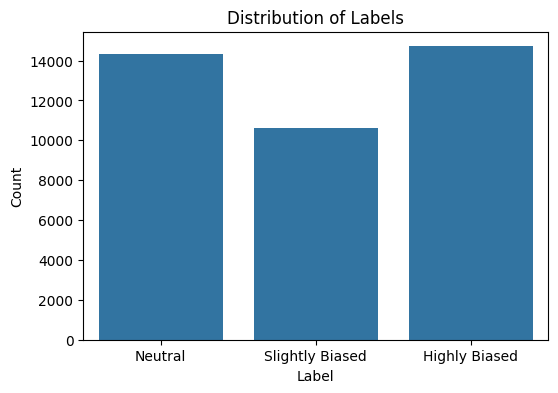

In [ ]:
# Visualize the distribution of labels
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=r_bias_data)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

From the above visualization, we can observe if there is any significant class imbalance in the label distribution which doesn't seem like it.
We can see that 'Neutral' and 'Highly Biased' classes have almost the same amount of instances with approximately a litte over 14,000. And 'Slightly Biased' class is a little lower at approximately 10,000 instances but not significantly underrepresented compared to the other two.

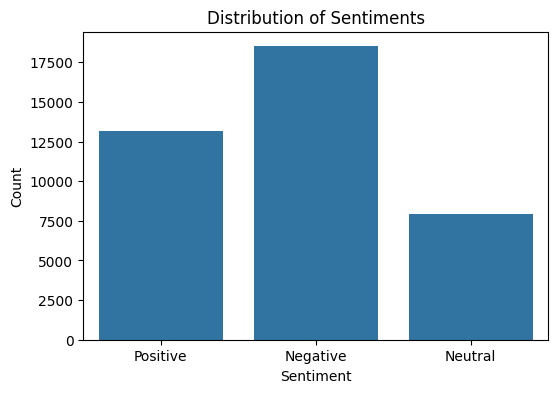

In [ ]:
# Visualize the distribution of sentiment
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=r_bias_data)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

From the above visualization, we can observe the overall sentiment in the dataset. It suggests that the majority of the content contains some form of negative emotions, with over 17,500 counts for negative class, followed by positive class with over 12,500 instances and then neutral with approximately 7,500 instances.

Next, using wordcloud library, we will visualize most common biased words in the news media dataset. We will extract all the biased words from the 'biased_words' column, convert the extracted word list it as a string and then generate word cloud visualization. The larger the size of each word the more frequent it is.

In [ ]:
# Extract all the biased words
all_biased_words = [word for words in r_bias_data['biased_words'] for word in eval(words)]

# Convert the extracted biased words into a string
biased_words_text = ' '.join(all_biased_words)

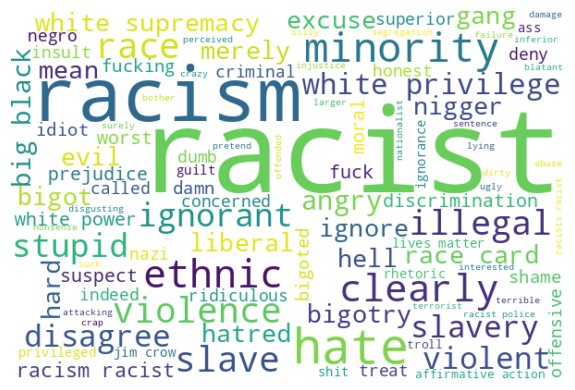

In [ ]:
# Visualize biased words in the news media dataset
wordcloud = WordCloud(width=600, height=400, background_color='white', colormap='viridis', max_words=100).generate(biased_words_text)

plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
#plt.title('Biased words in the news media')
plt.tight_layout()
plt.savefig('wordcloud')
plt.show()

From the above visualization, we can observe the high-level overview of the most common biased words present in the news media. Words such as 'white', 'black', 'negro', and 'nigger' indicate the presence of frequent deragatory terms and racial slurs. There is also presence of highly emotional and offensive language such as 'hate', 'evil', 'angry', 'damn', 'shit', 'fuck', 'dumb', 'idiot' and so on.


In [ ]:
# Replace similar words to the base words 
rep_dict = {
    'is racist': 'racist',
    'are racist': 'racist',
    'racists': 'racist',
    'slaves': 'slave',
}

# Count occurrence
freq = Counter([rep_dict.get(word, word) for word in all_biased_words])
# freq.most_common(15)

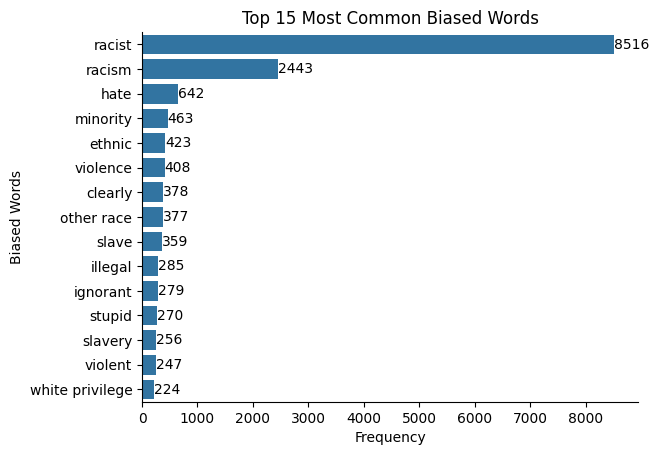

In [ ]:
# Create DataFrame
freq_df = pd.DataFrame(freq.most_common(15), columns=['biased_words', 'frequency'])

# Visualize the distribution of most common biased words
sns.barplot(x='frequency', y='biased_words', data=freq_df)
plt.title('Top 15 Most Common Biased Words')
plt.xlabel('Frequency')
plt.ylabel('Biased Words')

for index, value in enumerate(freq_df['frequency']):
    plt.text(value, index, f'{value}', color='black', va='center')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [ ]:
def clean_get_ngrams(text, n):
    text = text.lower()                             #convert text to lowercase
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)        #remove non-alphabetic characters
    tokens = nltk.word_tokenize(text)               #tokenize the text
    stop_words = set(stopwords.words('english'))    #remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()                #lemmatize tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    n_grams = ngrams(tokens, n)
    return [' '.join(grams) for grams in n_grams]

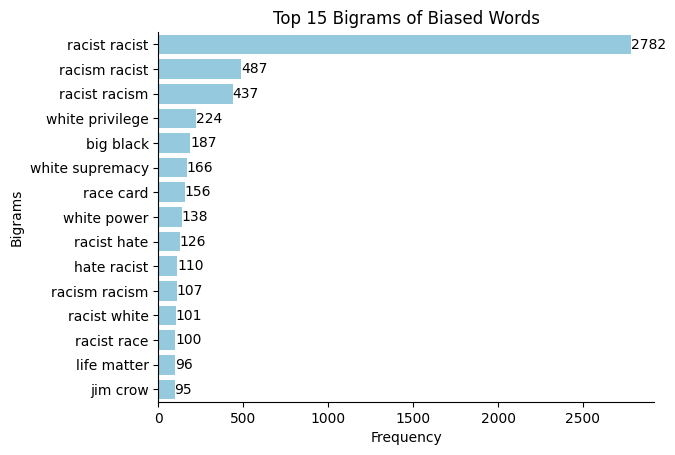

In [ ]:
bigram_freq = Counter(clean_get_ngrams(biased_words_text, 2))
bigram_df = pd.DataFrame(bigram_freq.most_common(15), columns=['bigrams', 'frequency'])

sns.barplot(x='frequency', y='bigrams', data=bigram_df, color='skyblue')
plt.title('Top 15 Bigrams of Biased Words')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')

for index, value in enumerate(bigram_df['frequency']):
    plt.text(value, index, f'{value}', color='black', va='center')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('bigrams')
plt.show()

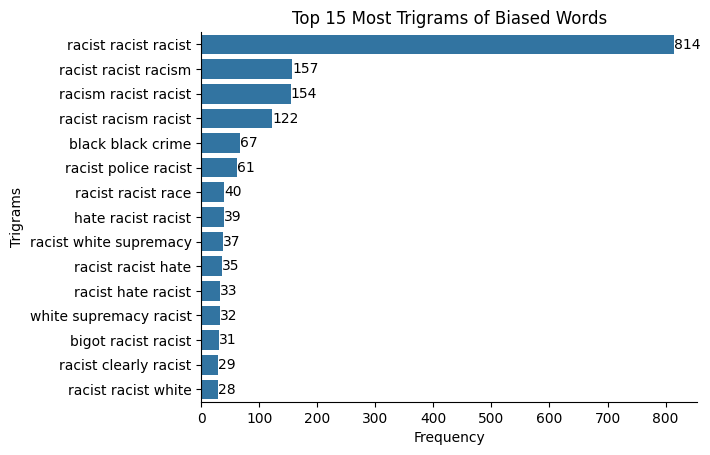

In [ ]:
trigram_freq = Counter(clean_get_ngrams(biased_words_text, 3))
trigram_df = pd.DataFrame(trigram_freq.most_common(15), columns=['trigrams', 'frequency'])

sns.barplot(x='frequency', y='trigrams', data=trigram_df)
plt.title('Top 15 Most Trigrams of Biased Words')
plt.xlabel('Frequency')
plt.ylabel('Trigrams')

for index, value in enumerate(trigram_df['frequency']):
    plt.text(value, index, f'{value}', color='black', va='center')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

Finally we will drop the columns not needed and save the cleaned DataFrame to a CSV file.

In [ ]:
# Drop columns we will not need for our analysis
columns_to_drop = ['dimension']
r_bias_data = r_bias_data.drop(columns=columns_to_drop)
r_bias_data.head()

,text,biased_words,aspect,label,sentiment,preprocessed_text
74,No picnic my phone smells like citrus.,[],Racial,Neutral,Positive,picnic phone smell like citrus
202,"@eloquentembrace You're going to kill me, but ...",[],Racial,Slightly Biased,Negative,going kill seen d waiting till one solid week ...
664,White trash vs us... We were outnumbered. htt...,['white trash'],Racial,Slightly Biased,Neutral,white trash v u outnumbered
1182,poor mel. Feeling your pain.,[],Racial,Slightly Biased,Negative,poor mel feeling pain
1377,I need some selsun blue...pretty sure i have a...,['rot'],Racial,Slightly Biased,Positive,need selsun blue pretty sure small spot haole rot


In [ ]:
# Save the cleaned DataFrame to a CSV file
#r_bias_data.to_csv('newsmediabias-clean.csv', index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b1c72295-175f-4acc-b145-1e90e876d4e6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>